# 1. Imports & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


from gensim.models import Word2Vec


SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

2026-02-06 09:17:53.853992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770369474.064415      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770369474.120750      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770369474.659182      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770369474.659218      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770369474.659222      24 computation_placer.cc:177] computation placer alr

# 2. Load Dataset

In [2]:
df = pd.read_csv("/kaggle/input/pricerunner/pricerunner_aggregate.csv")
df.head()

,Product ID,Product Title,Merchant ID,Cluster ID,Cluster Label,Category ID,Category Label
0,1,apple iphone 8 plus 64gb silver,1,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
1,2,apple iphone 8 plus 64 gb spacegrau,2,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
3,4,apple iphone 8 plus 64gb space grey,4,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones


# 3. Basic Preprocessing

In [3]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print(df.columns)


Index(['product_id', 'product_title', 'merchant_id', 'cluster_id',
       'cluster_label', 'category_id', 'category_label'],
      dtype='object')


# 4. Train-Test Split

In [4]:
texts = df["product_title"].astype(str).values
labels = df["category_label"].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

num_classes = len(np.unique(y))

X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


# 5. Dataset Exploration

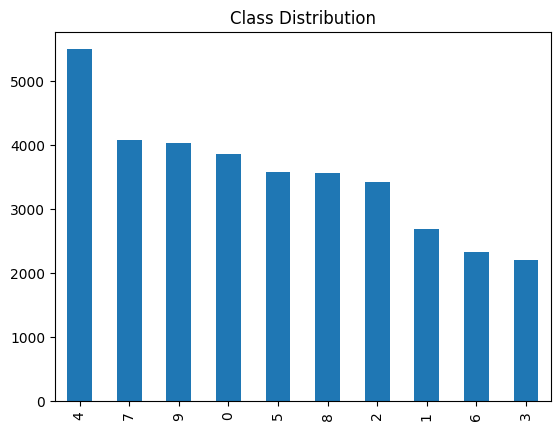

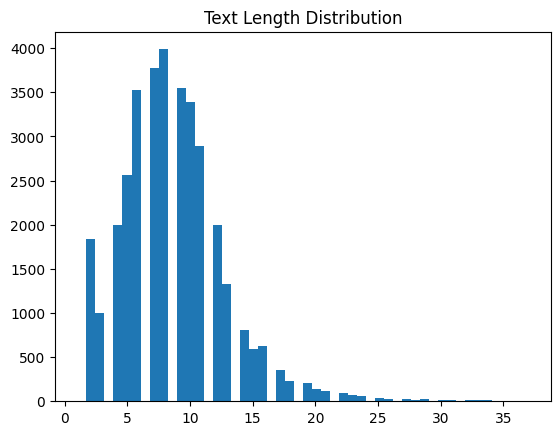

In [5]:
plt.figure()
pd.Series(y).value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.show()


text_lengths = [len(t.split()) for t in texts]
plt.figure()
plt.hist(text_lengths, bins=50)
plt.title("Text Length Distribution")
plt.show()

# 6. GRU with TF-IDF

In [6]:
print("\n--- GRU with TF-IDF ---")


max_features = 10000


tfidf = TfidfVectorizer(max_features=max_features)
X_train_tfidf = tfidf.fit_transform(X_train_text).toarray()
X_test_tfidf = tfidf.transform(X_test_text).toarray()


# Expand dims for GRU (timesteps=1)
X_train_tfidf = np.expand_dims(X_train_tfidf, axis=1)
X_test_tfidf = np.expand_dims(X_test_tfidf, axis=1)


model_tfidf = Sequential([
GRU(128, input_shape=(1, max_features)),
Dropout(0.5),
Dense(num_classes, activation='softmax')
])


model_tfidf.compile(
optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy']
)


model_tfidf.fit(
X_train_tfidf,
y_train_cat,
validation_split=0.1,
epochs=5,
batch_size=64
)

pred_tfidf = np.argmax(model_tfidf.predict(X_test_tfidf), axis=1)
print(classification_report(y_test, pred_tfidf))


--- GRU with TF-IDF ---


I0000 00:00:1770369511.657596      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770369511.663599      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5


I0000 00:00:1770369518.030489      69 cuda_dnn.cc:529] Loaded cuDNN version 91002


398/398 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6872 - loss: 1.5388 - val_accuracy: 0.9441 - val_loss: 0.2746
Epoch 2/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9606 - loss: 0.2142 - val_accuracy: 0.9678 - val_loss: 0.1508
Epoch 3/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9802 - loss: 0.1088 - val_accuracy: 0.9770 - val_loss: 0.1167
Epoch 4/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9875 - loss: 0.0697 - val_accuracy: 0.9805 - val_loss: 0.0999
Epoch 5/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9904 - loss: 0.0488 - val_accuracy: 0.9809 - val_loss: 0.0918
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       773
           1       1.00      0.99      1.00       540
           2       0.95      0.98      0.97       685
           3       0.98      0.94      0.96       442
           4       0.97      0.95      0.96      1100
         

# 7. Tokenization for Word2Vec

In [7]:
max_words = 20000
max_len = 20


tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)


X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)


X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


word_index = tokenizer.word_index
vocab_size = min(max_words, len(word_index) + 1)

# 8. Word2Vec Training (Skip-gram & CBOW)

In [8]:
train_tokens = [text.split() for text in X_train_text]


w2v_skip = Word2Vec(
    sentences=train_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    sg=1,
    workers=4,
    seed=SEED
)


w2v_cbow = Word2Vec(
    sentences=train_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    sg=0,
    workers=4,
    seed=SEED
)


def build_embedding_matrix(w2v_model):
    embedding_matrix = np.zeros((vocab_size, 100))
    for word, idx in word_index.items():
        if idx < vocab_size and word in w2v_model.wv:
            embedding_matrix[idx] = w2v_model.wv[word]
    return embedding_matrix


embedding_skip = build_embedding_matrix(w2v_skip)
embedding_cbow = build_embedding_matrix(w2v_cbow)

# 9. GRU Model Builder

In [9]:
def build_gru_model(embedding_matrix):
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=100,
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=False
        ),
        GRU(128),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 10. GRU + Skip-gram

In [10]:
print("\n--- GRU with Word2Vec Skip-gram ---")
model_skip = build_gru_model(embedding_skip)
model_skip.fit(
    X_train_pad,
    y_train_cat,
    validation_split=0.1,
    epochs=5,
    batch_size=64
)


pred_skip = np.argmax(model_skip.predict(X_test_pad), axis=1)
print(classification_report(y_test, pred_skip))


--- GRU with Word2Vec Skip-gram ---
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


398/398 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4972 - loss: 1.3059 - val_accuracy: 0.8754 - val_loss: 0.3098
Epoch 2/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8923 - loss: 0.2890 - val_accuracy: 0.9402 - val_loss: 0.1857
Epoch 3/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9389 - loss: 0.1880 - val_accuracy: 0.9434 - val_loss: 0.1635
Epoch 4/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9431 - loss: 0.1628 - val_accuracy: 0.9490 - val_loss: 0.1493
Epoch 5/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9471 - loss: 0.1515 - val_accuracy: 0.9469 - val_loss: 0.1515
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       773
           1       0.99      0.99      0.99       540
           2       0.86      0.98      0.91       685
           3       0.85      0.87      0.86       442
           4       0.95      0.90      0.92      1100
         

# 11. GRU + CBOW

In [11]:
print("\n--- GRU with Word2Vec CBOW ---")
model_cbow = build_gru_model(embedding_cbow)
model_cbow.fit(
    X_train_pad,
    y_train_cat,
    validation_split=0.1,
    epochs=5,
    batch_size=64
)


pred_cbow = np.argmax(model_cbow.predict(X_test_pad), axis=1)
print(classification_report(y_test, pred_cbow))


--- GRU with Word2Vec CBOW ---
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


398/398 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5463 - loss: 1.2213 - val_accuracy: 0.9065 - val_loss: 0.2744
Epoch 2/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9124 - loss: 0.2693 - val_accuracy: 0.9221 - val_loss: 0.2321
Epoch 3/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9215 - loss: 0.2307 - val_accuracy: 0.9313 - val_loss: 0.1991
Epoch 4/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9291 - loss: 0.2095 - val_accuracy: 0.9303 - val_loss: 0.1986
Epoch 5/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9324 - loss: 0.1965 - val_accuracy: 0.9363 - val_loss: 0.1849
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       773
           1       0.99      0.99      0.99       540
           2       0.87      0.94      0.90       685
           3       0.96      0.82      0.88       442
           4       0.96      0.86      0.91      1100
         

# 12. Summary Table

In [12]:
results = pd.DataFrame({
    'Model': ['GRU'],
    'TF-IDF': [accuracy_score(y_test, pred_tfidf)],
    'Skip-gram': [accuracy_score(y_test, pred_skip)],
    'CBOW': [accuracy_score(y_test, pred_cbow)]
})


print(results)

  Model   TF-IDF  Skip-gram      CBOW
0   GRU  0.97409   0.946765  0.933881
